# Data Synthesizer DTTD
[DataSynthesizer](https://github.com/DataResponsibly/DataSynthesizer?tab=readme-ov-file) is a package made by MIT researchers Haoyue Ping, Julia Stoyanovich, and Bill Howe. It's purpose is to make to synthetic (fake) data from an existing dataset. The output is synthetic data that exhibits the same properties as original data.

There are many instances in which it can be important to have synthetic data. For example, medical data that should not be viewed by third parties (due to HIPPA requirements), but contains important insights into the included population.

This package works by generating a Bayesian network of which variables are most closely correlated with each other and then creating the data column by column to satisfy the network. In doing so, it should make a dataset that has not private information, but still contains all relevant descriptive statistics of the original. This new data can be shared and used in predictive models without worry of violating the privacy of the data.

In [3]:
# install the package!
!pip install DataSynthesizer

DEPRECATION: xgbse 0.2.3 has a non-standard dependency specifier pandas>=1.0.*. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of xgbse or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063


In [5]:
# import necessary package (DataSynthesizer)
from DataSynthesizer.DataDescriber import DataDescriber
from DataSynthesizer.DataGenerator import DataGenerator
from DataSynthesizer.ModelInspector import ModelInspector
from DataSynthesizer.lib.utils import read_json_file, display_bayesian_network

# and other basic python packages
import pandas as pd
from sklearn import datasets

In [6]:
# load in our toy dataset, which contains information about patients with diabetes
diab = datasets.load_diabetes()
diab_df = pd.DataFrame(data=diab.data, columns=diab.feature_names)

# Add the target variable (a value representing the progression of diabetes) to the DataFrame
diab_df['target'] = diab.target
diab_df.to_csv('diabetes.csv', index=False)

In [7]:
diab_df.head()

age       sex       bmi        bp        s1        s2        s3  \
0  0.038076  0.050680  0.061696  0.021872 -0.044223 -0.034821 -0.043401   
1 -0.001882 -0.044642 -0.051474 -0.026328 -0.008449 -0.019163  0.074412   
2  0.085299  0.050680  0.044451 -0.005670 -0.045599 -0.034194 -0.032356   
3 -0.089063 -0.044642 -0.011595 -0.036656  0.012191  0.024991 -0.036038   
4  0.005383 -0.044642 -0.036385  0.021872  0.003935  0.015596  0.008142   

         s4        s5        s6  target  
0 -0.002592  0.019907 -0.017646   151.0  
1 -0.039493 -0.068332 -0.092204    75.0  
2 -0.002592  0.002861 -0.025930   141.0  
3  0.034309  0.022688 -0.009362   206.0  
4 -0.002592 -0.031988 -0.046641   135.0

In [8]:
# set the threshold_value, number of different values in a column for the column to be treated as numerical or categorical
threshold_value = 5 # define categorial variables with domain size
# double check to make sure sex is set as a categorical variable
categorical_attributes = {'sex': True} #define categorical variables by naming columns

In [7]:
# first step of making Bayesian network from original data
describer = DataDescriber(category_threshold=threshold_value)
describer.describe_dataset_in_correlated_attribute_mode(dataset_file='diabetes.csv', 
                                                        epsilon=0, # 0 epsilpon means no noise added
                                                        k=2, # k = number of correlated columns
                                                        attribute_to_is_categorical=categorical_attributes)
describer.save_dataset_description_to_file('diabetes_descriptor.json') # generator saved to json

================ Constructing Bayesian Network (BN) ================
Adding ROOT s3
Adding attribute s4
Adding attribute s1
Adding attribute s2
Adding attribute target
Adding attribute age
Adding attribute bp
Adding attribute s5
Adding attribute bmi
Adding attribute s6
Adding attribute sex
========================== BN constructed ==========================


In [8]:
# second step of creating synthetic data column by column
generator = DataGenerator()
generator.generate_dataset_in_correlated_attribute_mode(1000, 'diabetes_descriptor.json')
generator.save_synthetic_data('syn_diabetes.csv') #new data outputted to csv

### Figures to compare real and synthetic data!

In [9]:
# Read both datasets using Pandas
input_df = pd.read_csv('diabetes.csv', skipinitialspace=True)
synthetic_df = pd.read_csv('syn_diabetes.csv')
# Read attribute description from the dataset description file.
attribute_description = read_json_file('diabetes_descriptor.json')['attribute_description']
# inspector object is just to allow us to quickly compare columns using histograms below
inspector = ModelInspector(input_df, synthetic_df, attribute_description)

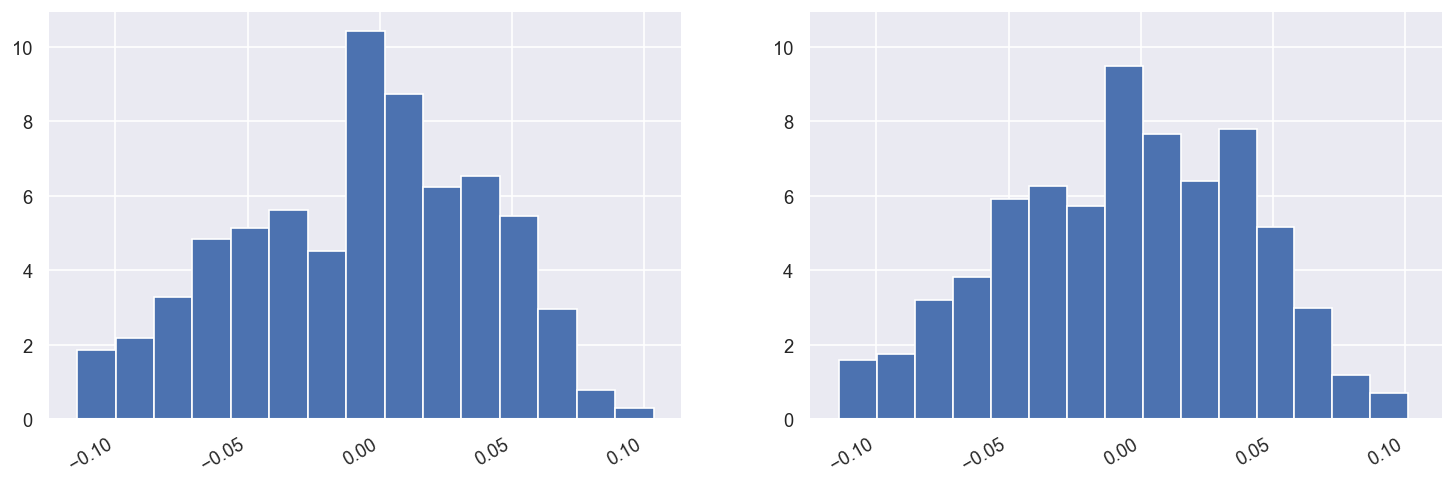

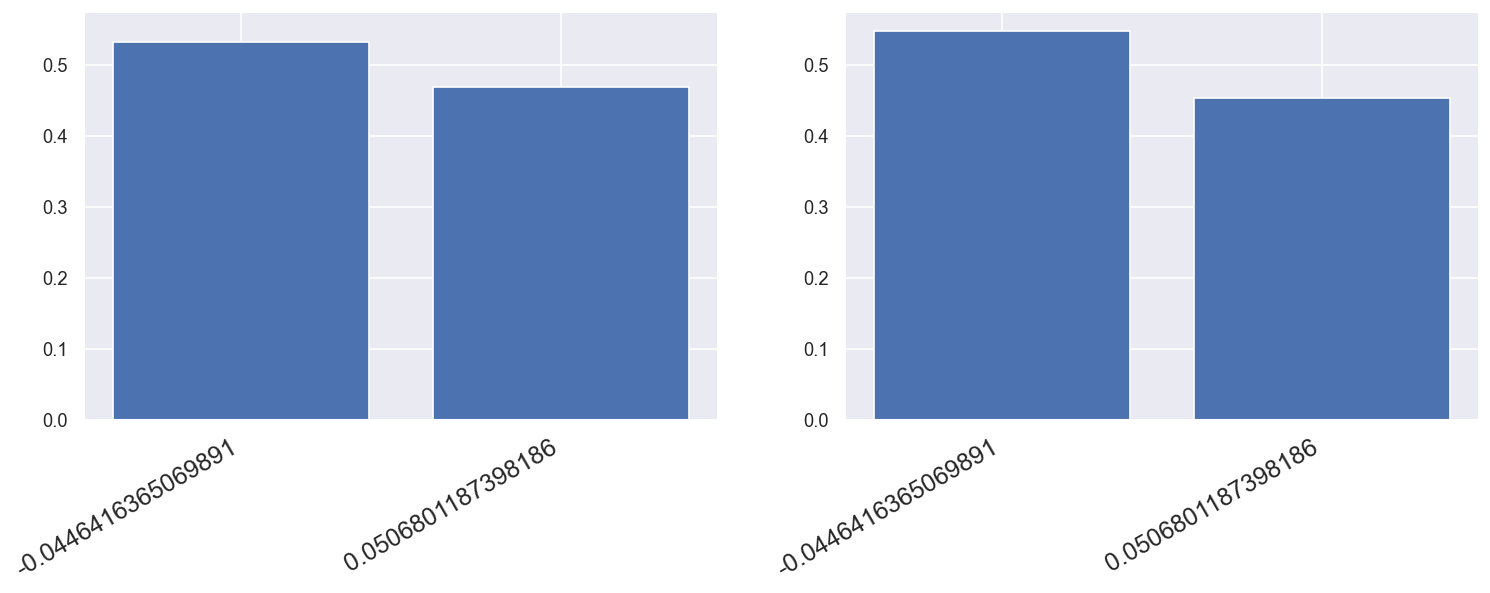

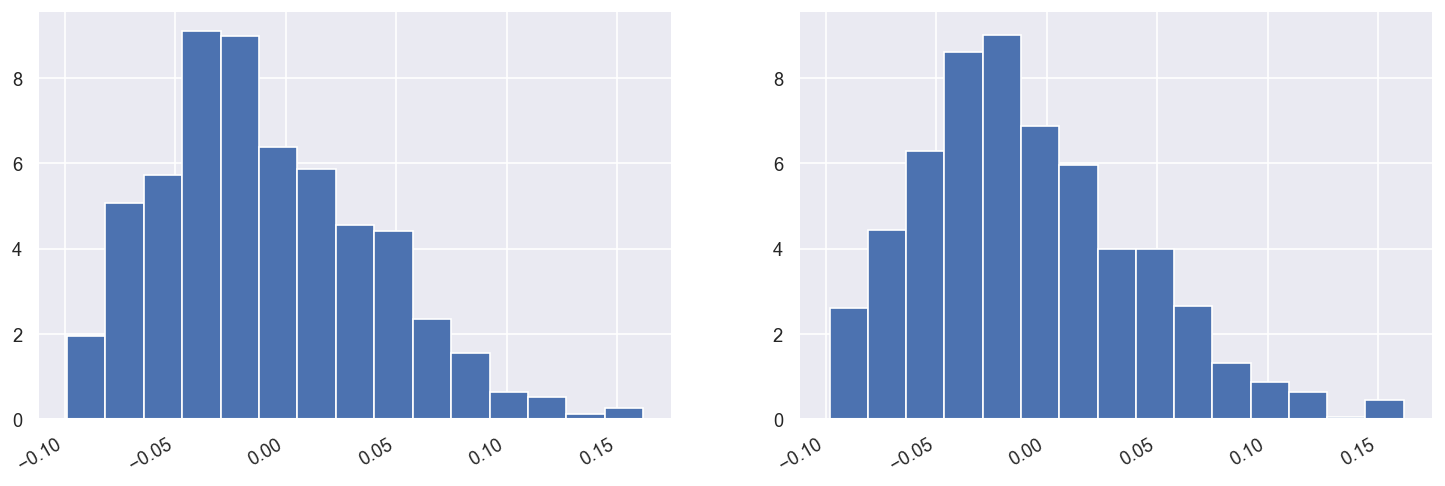

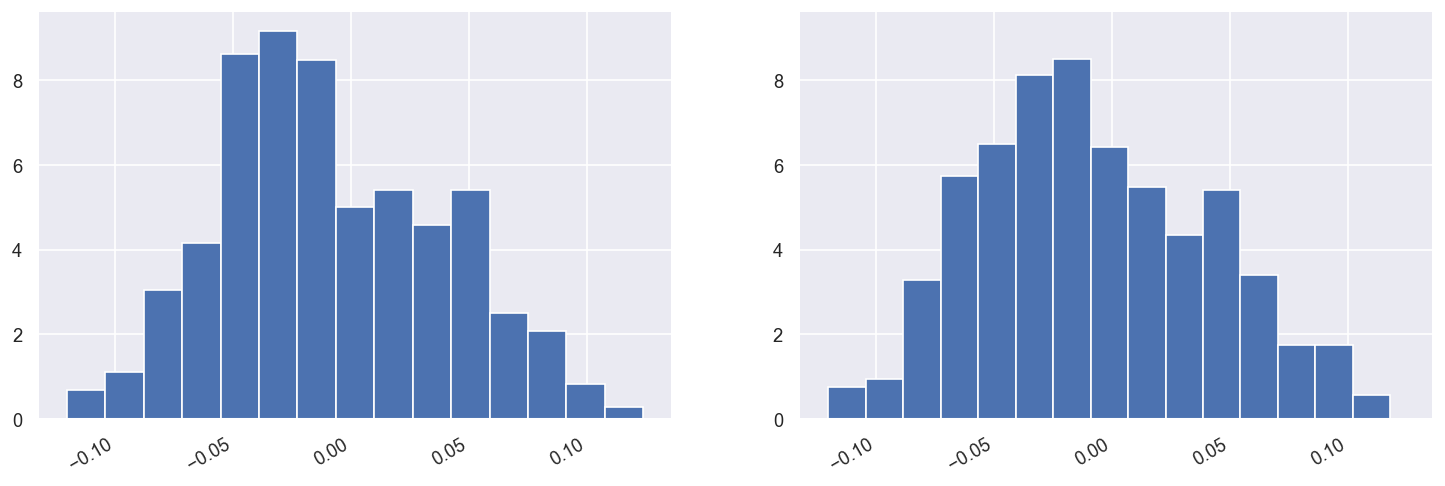

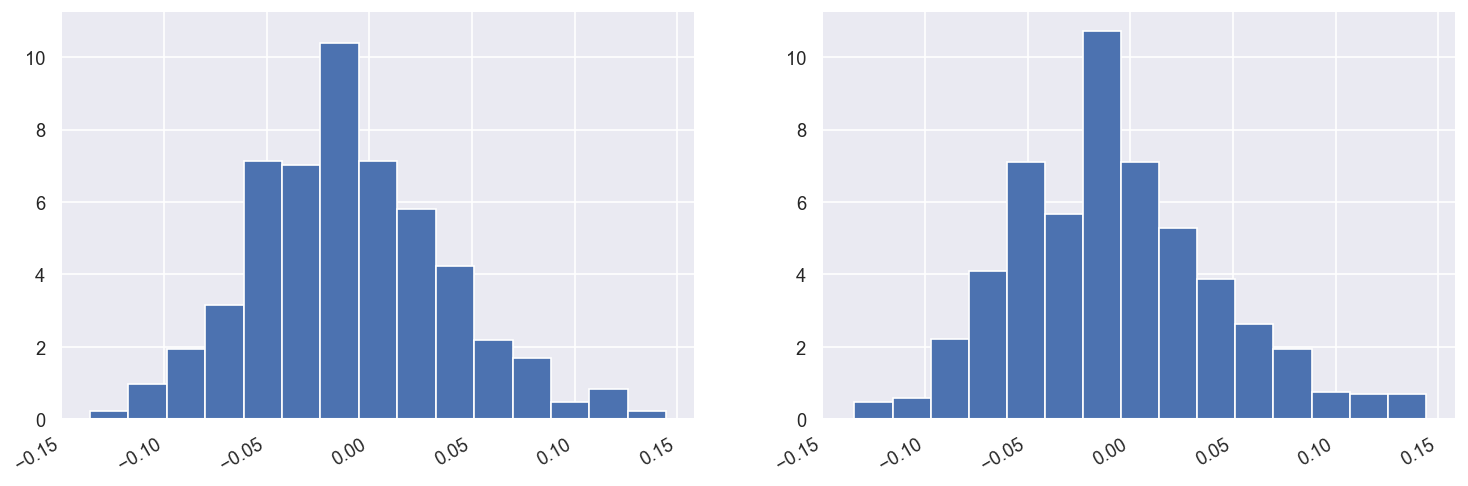

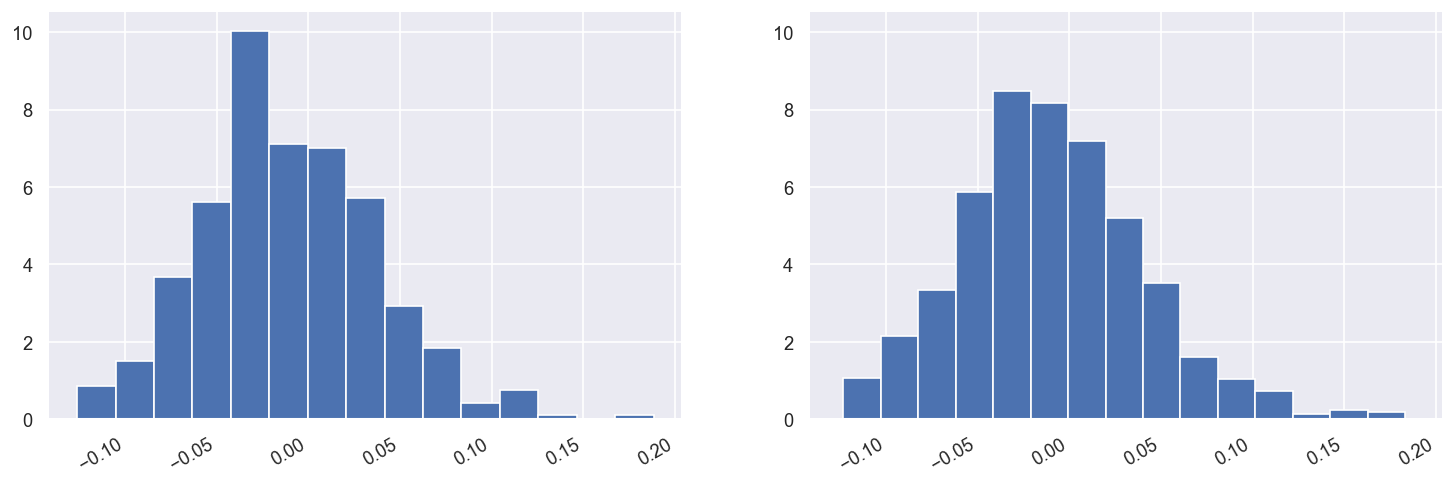

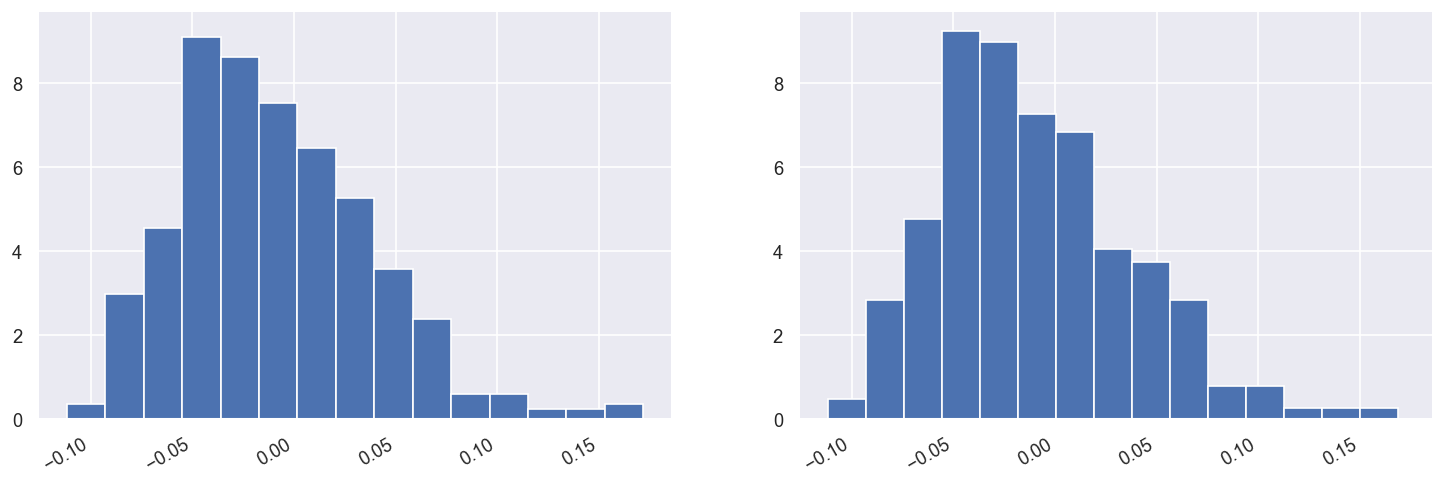

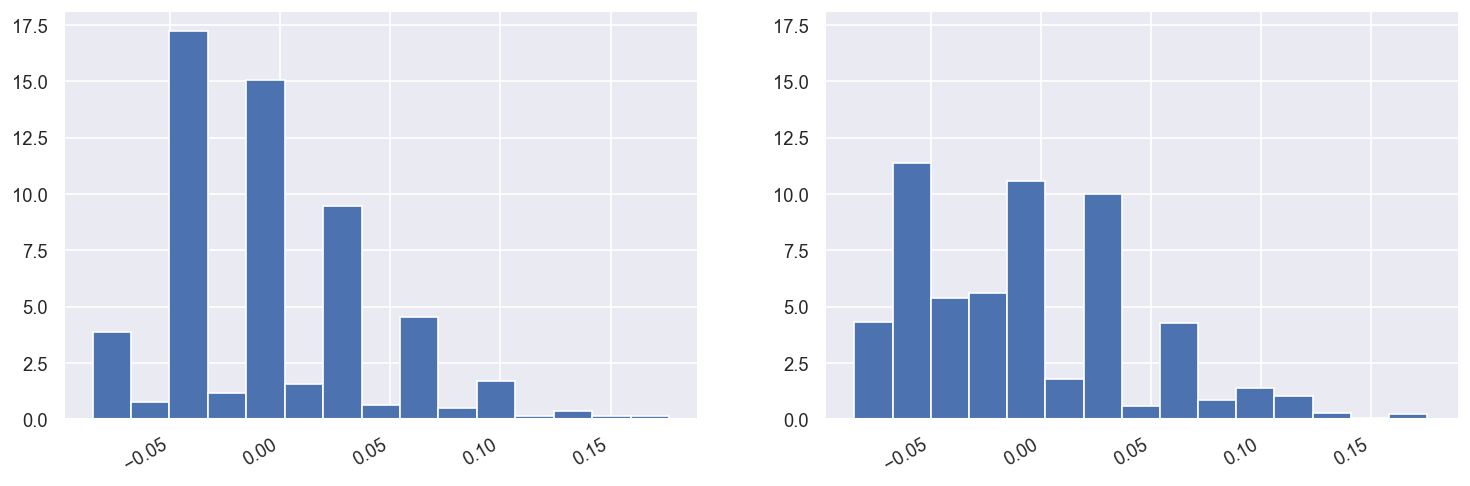

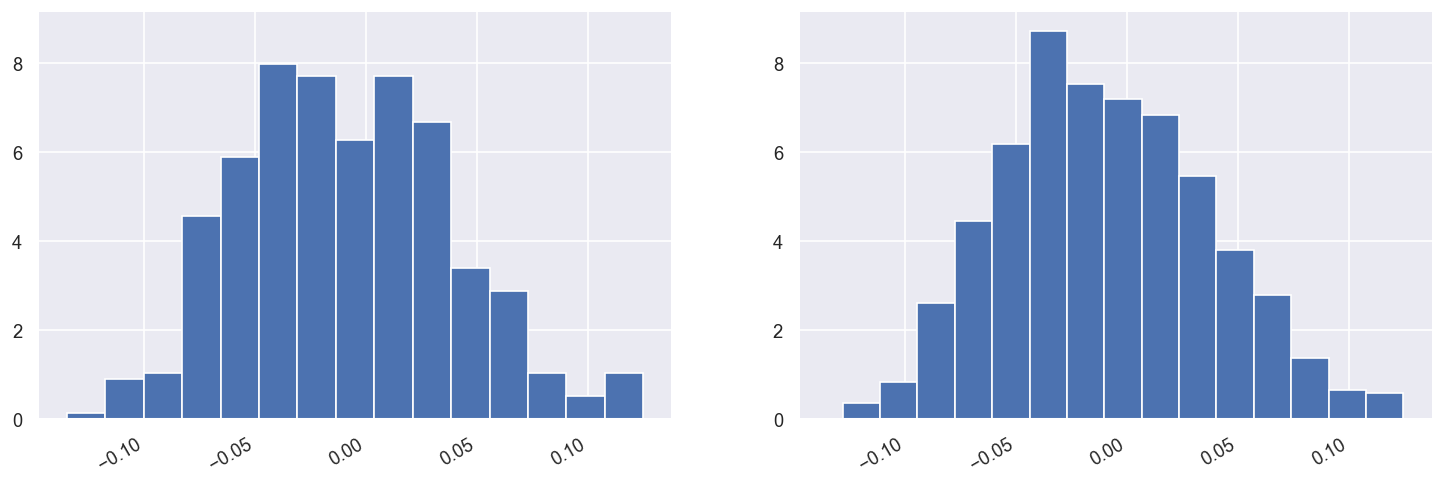

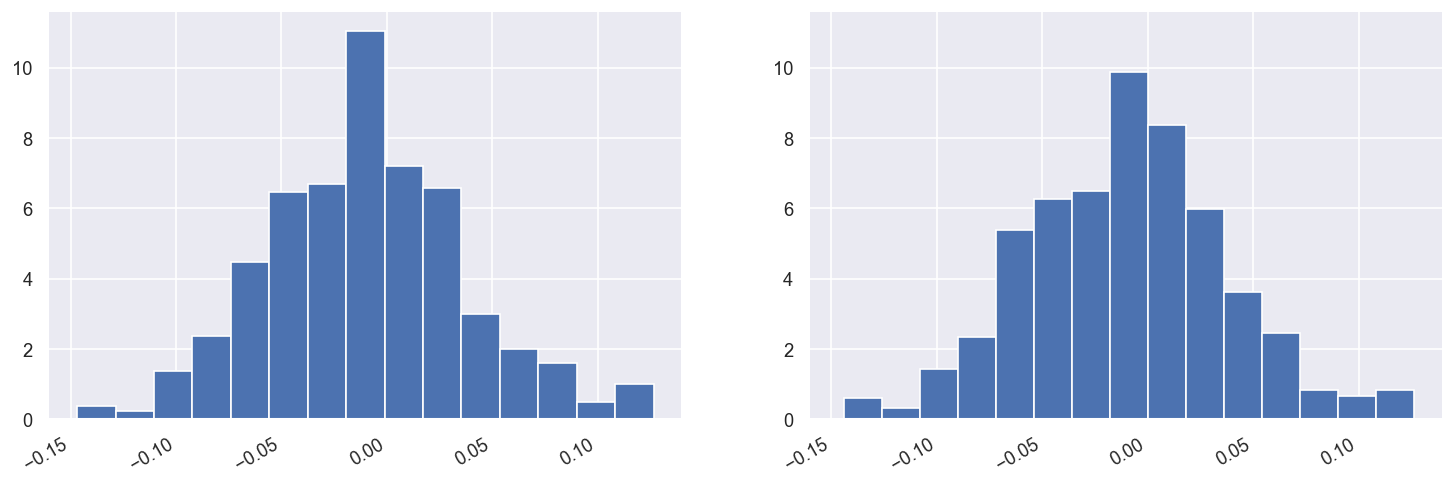

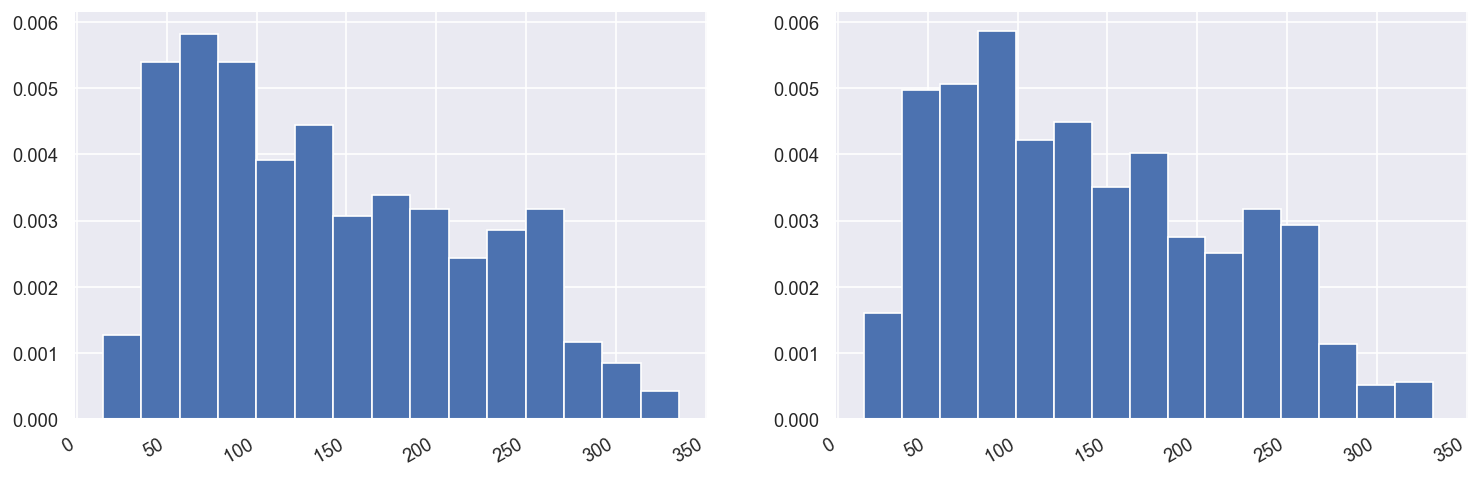

In [10]:
# make a bunch of histograms to compare the distribution of values in different variables from original and synthetic data
for attribute in synthetic_df.columns:
    inspector.compare_histograms(attribute) #visually compare histograms of original and synthetic data

#### Now some heatmaps to show correlation between variables in original and synthetic datasets

<Axes: >

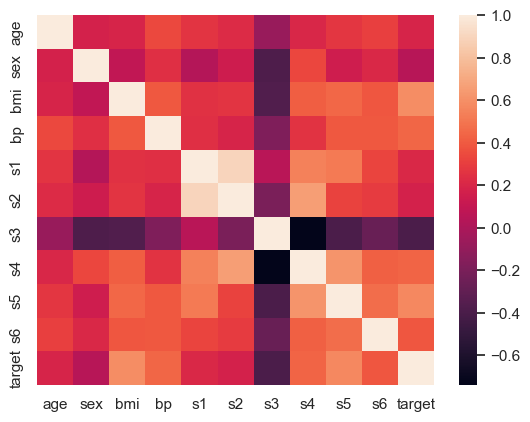

In [9]:
import seaborn as sns
syn = pd.read_csv('syn_diabetes.csv', skipinitialspace=True)
syncorr = syn.corr()
corr = diab_df.corr()
sns.heatmap(corr) #visually compare correlation matrix of original and synthetic data

<Axes: >

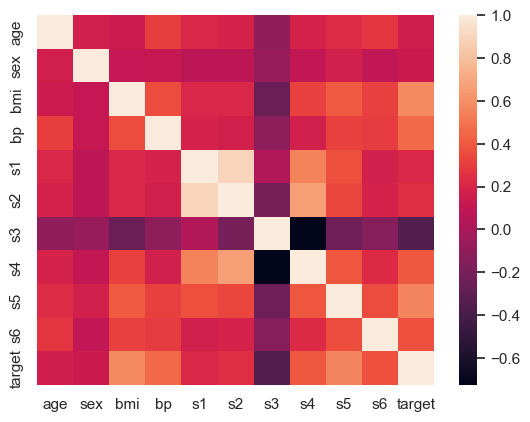

In [10]:
sns.heatmap(syncorr)